## 实验：MNIST 权重初始值对比

### 实验概要

深度学习框架中往往会包含大量可以被调用的初始化工具，用于定义设置神经网络各层权重随机初始值的方法。

```python
import tensorflow.keras as keras

#  ######################可用初始化器汇总########################
keras.initializers.Initializer()  # 初始化器基类：所有初始化器继承这个类。
keras.initializers.Zeros()  # 将张量初始值设为 0 的初始化器。
keras.initializers.Ones()  # 将张量初始值设为 1 的初始化器。将张量初始值设为 1 的初始化器。将张量初始值设为 1 的初始化器。
keras.initializers.Constant(value=0)  # 将张量初始值设为一个常数的初始化器。value: 浮点数，生成的张量的值。
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)  # 按照正态分布生成随机张量的初始化器。
keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  # 按照均匀分布生成随机张量的初始化器。
keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)  # 按照截尾正态分布生成随机张量的初始化器。
keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)  # 初始化器能够根据权值的尺寸调整其规模。
keras.initializers.Orthogonal(gain=1.0, seed=None)  # 生成一个随机正交矩阵的初始化器。
keras.initializers.Identity(gain=1.0)  # 生成单位矩阵的初始化器。
keras.initializers.lecun_uniform(seed=None)  # LeCun 均匀初始化器。
keras.initializers.glorot_normal(seed=None)  # keras.initializers.glorot_normal(seed=None)
keras.initializers.glorot_uniform(seed=None)  # Glorot 均匀分布初始化器，也称为 Xavier 均匀分布初始化器。
keras.initializers.he_normal(seed=None)  # He 正态分布初始化器。
keras.initializers.lecun_normal(seed=None)  # LeCun 正态分布初始化器。
keras.initializers.he_uniform(seed=None)  # He 均匀方差缩放初始化器。
```

### 实验目标

在本实验中，我们将通过 TensorFlow （以 Keras 作为前端），实现了分别通过：`正态分布随机值`，`Xavier/Glorot 权重初始值`，以及 `HE 权重初始值` 对 MNIST 数据集，在相同的神经网络架构中进行训练。从而，对比各个权重初始化策略对模型训练正确率以及学习效率的影响。注意：`正态分布随机值`，`Xavier/Glorot 权重初始值`，以及 `HE 权重初始值` 仅仅是 TensorFlow 所支持的多种初始化策略中的一部分，最新完整的初始化列表可以 [查阅官方文档](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)。

### 1. 导入库

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os

### 2. 数据加载

MNIST 是 TensorFlow 的内置数据集，直接从框架中导入即可。

```keras.datasets.mnist.load_data()```

但由于需要从互联网上下载，连接可能不稳定，我们直接下载到本地，使用下面的代码进行加载。

与之前实验一样，训练集与测试据依然是 60000 张 / 10000 张 `28*28` 像素图片。

In [2]:
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab17/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

path = data_path+'mnist.npz'

f = np.load(path)
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(60000, 784)   (60000,)
(10000, 784)   (10000,)


在这个实验中，由于我们采用全连接（Dense / 密集）层架构作为输入层，而 [当前全连接层仅应用在输入数组的最后一个轴上](https://github.com/keras-team/keras/issues/10736) 。譬如：假如你输入了一个图像的多维数组 (height, width) 或者 (height, width, channels)；那么全连接层只会采用最后一个轴，即：`width` 或者 `channels`；所以在输入神经网络前，我们需要使用 `reshape()` 函数，将图片『拉直』，就是把 28x28 的数组，变为 784 的一维数组。

<img src="./img/1_17.png" width="80%">

目前这个 issue 还在打开的状态，也看不出开发者有将它关闭的意思。大部分情况下我们都不会将全连接层作为输入层设置，这里只是为了简化实验结构。

### 3. 模型搭建

我们将构建一个以 `Relu` 作为主要激活函数的神经网络，仅在最后的输出层采用 `Softmax`，同时为了简化架构，全部采用全连接（Dense / 密集）层模型。

我们采用全连接层架构作为输入层，输入的一维数组尺寸是 `784` ，输出的一维数组尺寸是 `64`。因此，我们在

- 输入层：**784x64（权重）+ 64（偏置）= 50240** 个参数
- 两层隐藏层：**64x64（权重）+ 64（偏置）= 4160** 个参数
- 输出层：**64x10（权重）+ 10（偏置）= 650** 个参数

整个神经网络架构的参数总和即：**50240 + 4160 + 4160 + 650 = 59210** 个参数。

In [3]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


### 4. 模型训练

在训练过程中，可以通过设置 `model.fit()` 函数的 `verbose` 参数控制是否显示训练进度，以及训练进度的显示方式：

- **`verbose=0`：** 不显示进度
- **`verbose=1`：** 显示详细进度条
- **`verbose=2`：** 显示进度概要

详细信息可 [查阅官方文档](https://keras.io/api/models/model_training_apis/#fit-method)

> **预计训练时间 5 分钟，请耐心等待**

In [4]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, 
                    validation_split=0.3, verbose=1)

Epoch 1/100
165/165 [==============================] - 4s 15ms/step - loss: 3.1775 - accuracy: 0.7066 - val_loss: 0.7677 - val_accuracy: 0.8412
Epoch 2/100
165/165 [==============================] - 2s 13ms/step - loss: 0.5592 - accuracy: 0.8692 - val_loss: 0.5137 - val_accuracy: 0.8793
Epoch 3/100
165/165 [==============================] - 2s 14ms/step - loss: 0.3601 - accuracy: 0.9054 - val_loss: 0.4136 - val_accuracy: 0.9028
Epoch 4/100
165/165 [==============================] - 3s 16ms/step - loss: 0.2686 - accuracy: 0.9238 - val_loss: 0.3658 - val_accuracy: 0.9125
Epoch 5/100
165/165 [==============================] - 2s 12ms/step - loss: 0.2174 - accuracy: 0.9376 - val_loss: 0.3102 - val_accuracy: 0.9234
Epoch 6/100
165/165 [==============================] - 2s 12ms/step - loss: 0.1808 - accuracy: 0.9468 - val_loss: 0.2842 - val_accuracy: 0.9307
Epoch 7/100
165/165 [==============================] - 2s 12ms/step - loss: 0.1503 - accuracy: 0.9551 - val_loss: 0.2834 - val_accuracy:

165/165 [==============================] - 2s 12ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.3492 - val_accuracy: 0.9590
Epoch 58/100
165/165 [==============================] - 2s 11ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.3503 - val_accuracy: 0.9601
Epoch 59/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.3655 - val_accuracy: 0.9579
Epoch 60/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0297 - accuracy: 0.9918 - val_loss: 0.3486 - val_accuracy: 0.9572
Epoch 61/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0283 - accuracy: 0.9920 - val_loss: 0.3360 - val_accuracy: 0.9598
Epoch 62/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.3372 - val_accuracy: 0.9626
Epoch 63/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0376 - accuracy: 0.9902 - val_loss: 0.3578 - val_accuracy: 0.959

### 5. 训练集和验证集准确率可视化

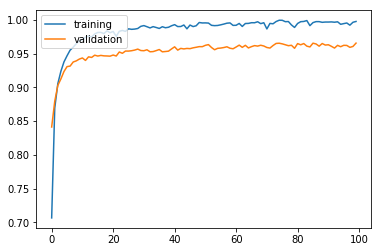

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### 6. 模型验证

In [6]:
result = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2887 - accuracy: 0.9670


以上是采用 Keras 默认初始化程序的训练结果。对于 Keras 而言，每一层都有其自己的默认值以初始化权重。对于大多数层，例如 Dense，卷积和 RNN 层，默认的内核初始化程序是 `glorot_uniform`，默认的偏置初始化器是 `zeros`。

### 7. 定义权重初始化函数

定义一个通用函数，在后面我们只需要修改输入值，便能更换初始化方法对模型进行重训练。

In [7]:
def weight_model(kernel):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', kernel_initializer=kernel, input_shape=(784,)),
        layers.Dense(64, activation='relu', kernel_initializer=kernel),
        layers.Dense(64, activation='relu', kernel_initializer=kernel),
        layers.Dense(10, activation='softmax')
    ])
    return model

### 8. 正态分布随机权重初始化

将各层的默认初始化器，统一修改为正态分布随机权重初始化，重新训练网络。

In [8]:
weight_model("random_normal")
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


#### 8.1 模型训练

> **预计训练时间 5 分钟，请耐心等待**

In [9]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, 
                    validation_split=0.3, verbose=1)

Epoch 1/100
165/165 [==============================] - 8s 20ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.4029 - val_accuracy: 0.9655
Epoch 2/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.4152 - val_accuracy: 0.9647
Epoch 3/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.4361 - val_accuracy: 0.9606
Epoch 4/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 0.4308 - val_accuracy: 0.9608
Epoch 5/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.4330 - val_accuracy: 0.9612
Epoch 6/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.4332 - val_accuracy: 0.9630
Epoch 7/100
165/165 [==============================] - 3s 19ms/step - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.3903 - val_accuracy:

165/165 [==============================] - 3s 20ms/step - loss: 0.0187 - accuracy: 0.9955 - val_loss: 0.4626 - val_accuracy: 0.9620
Epoch 58/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.4642 - val_accuracy: 0.9609
Epoch 59/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.4030 - val_accuracy: 0.9665
Epoch 60/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0137 - accuracy: 0.9972 - val_loss: 0.4337 - val_accuracy: 0.9638
Epoch 61/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0154 - accuracy: 0.9965 - val_loss: 0.4258 - val_accuracy: 0.9634
Epoch 62/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.4116 - val_accuracy: 0.9667
Epoch 63/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.4070 - val_accuracy: 0.965

#### 8.2 训练集和验证集准确率可视化

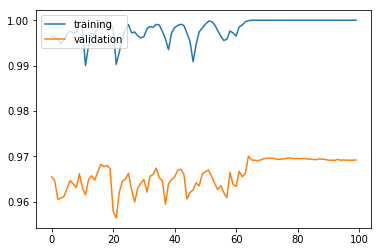

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### 9. Xavier 权重初始值

将各层的默认初始化器，统一修改为 Xavier 权重初始值，重新训练网络。

In [11]:
weight_model("glorot_normal")
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


#### 9.1 模型训练

> **预计训练时间 5 分钟，请耐心等待**

In [12]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, 
                    validation_split=0.3, verbose=1)

Epoch 1/100
165/165 [==============================] - 4s 14ms/step - loss: 0.0100 - accuracy: 0.9979 - val_loss: 0.5831 - val_accuracy: 0.9641
Epoch 2/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0136 - accuracy: 0.9976 - val_loss: 0.6444 - val_accuracy: 0.9609
Epoch 3/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0092 - accuracy: 0.9980 - val_loss: 0.5558 - val_accuracy: 0.9643
Epoch 4/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0063 - accuracy: 0.9986 - val_loss: 0.4899 - val_accuracy: 0.9659
Epoch 5/100
165/165 [==============================] - 2s 11ms/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 0.5335 - val_accuracy: 0.9627
Epoch 6/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.4939 - val_accuracy: 0.9652
Epoch 7/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.5234 - val_accuracy:

165/165 [==============================] - 2s 14ms/step - loss: 0.0163 - accuracy: 0.9969 - val_loss: 0.4655 - val_accuracy: 0.9668
Epoch 58/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.5414 - val_accuracy: 0.9654
Epoch 59/100
165/165 [==============================] - 2s 15ms/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 0.5521 - val_accuracy: 0.9662
Epoch 60/100
165/165 [==============================] - 2s 15ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.4793 - val_accuracy: 0.9684
Epoch 61/100
165/165 [==============================] - 2s 12ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.5073 - val_accuracy: 0.9675
Epoch 62/100
165/165 [==============================] - 2s 14ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.4981 - val_accuracy: 0.9678
Epoch 63/100
165/165 [==============================] - 2s 13ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.5310 - val_accuracy: 0.968

#### 9.2 训练集和验证集准确率可视化

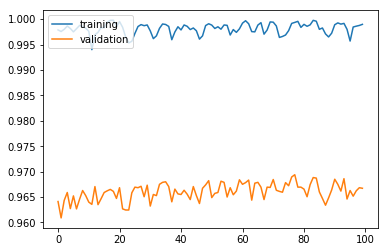

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### 10. HE 权重初始值

将各层的默认初始化器，统一修改为 HE 权重初始值，重新训练网络。

In [14]:
weight_model("he_normal")
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


#### 10.1 模型训练

> **预计训练时间 5 分钟，请耐心等待**

In [15]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, 
                    validation_split=0.3, verbose=1)

Epoch 1/100
165/165 [==============================] - 4s 15ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.6589 - val_accuracy: 0.9657
Epoch 2/100
165/165 [==============================] - 1s 9ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.6853 - val_accuracy: 0.9642
Epoch 3/100
165/165 [==============================] - 1s 9ms/step - loss: 0.0141 - accuracy: 0.9978 - val_loss: 0.6494 - val_accuracy: 0.9645
Epoch 4/100
165/165 [==============================] - 1s 8ms/step - loss: 0.0172 - accuracy: 0.9973 - val_loss: 0.5838 - val_accuracy: 0.9659
Epoch 5/100
165/165 [==============================] - 1s 8ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.5391 - val_accuracy: 0.9671
Epoch 6/100
165/165 [==============================] - 1s 8ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.6037 - val_accuracy: 0.9679
Epoch 7/100
165/165 [==============================] - 1s 7ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.5534 - val_accuracy: 0.969

165/165 [==============================] - 2s 10ms/step - loss: 1.9160e-07 - accuracy: 1.0000 - val_loss: 0.6210 - val_accuracy: 0.9701
Epoch 57/100
165/165 [==============================] - 2s 10ms/step - loss: 1.7687e-07 - accuracy: 1.0000 - val_loss: 0.6225 - val_accuracy: 0.9701
Epoch 58/100
165/165 [==============================] - 2s 9ms/step - loss: 1.6331e-07 - accuracy: 1.0000 - val_loss: 0.6239 - val_accuracy: 0.9701
Epoch 59/100
165/165 [==============================] - 2s 9ms/step - loss: 1.5131e-07 - accuracy: 1.0000 - val_loss: 0.6254 - val_accuracy: 0.9701
Epoch 60/100
165/165 [==============================] - 2s 10ms/step - loss: 1.3928e-07 - accuracy: 1.0000 - val_loss: 0.6270 - val_accuracy: 0.9700
Epoch 61/100
165/165 [==============================] - 2s 10ms/step - loss: 1.2859e-07 - accuracy: 1.0000 - val_loss: 0.6284 - val_accuracy: 0.9700
Epoch 62/100
165/165 [==============================] - 2s 10ms/step - loss: 1.1883e-07 - accuracy: 1.0000 - val_loss: 0.

#### 10.2 训练集和验证集准确率可视化

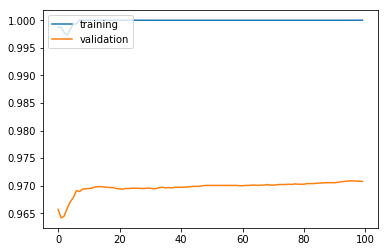

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### 实验小结

在本实验中，你实现了分别通过：`正态分布随机值`，`Xavier/Glorot 权重初始值`，以及 `HE 权重初始值` 对相同的数据集与神经网络架构进行训练。通过上述结果对比，可以看出三种权重初始值最终的准确率接近。然而，`HE 初始值` 明显比其他两个更快进入平稳收敛状态，也验证了 `HE 初始值` 与 `RuLu 激活函数` 是更理想的搭配组合。